In [1]:
import re

def parse_meal_name(meal_name):
    """
    Parse complex meal name into list of basic food items.
    """
    if not isinstance(meal_name, str):
        return []
    
    meal_name = meal_name.lower()
    
    # Rules for splitting
    separators = [" with ", " and ", " on ", " served with ", ",", ";", "&"]
    for sep in separators:
        meal_name = meal_name.replace(sep, "|")
    
    components = meal_name.split("|")
    components = [comp.strip().title() for comp in components if comp.strip()]
    
    # Optional: clean out modifier words
    modifier_words = ["Gluten-Free", "Low-Fat", "Organic", "Homemade", "Fresh"]
    cleaned_components = []
    for comp in components:
        for modifier in modifier_words:
            comp = comp.replace(modifier, "")
        cleaned_components.append(comp.strip())
    
    return cleaned_components

# 🧪 Quick test
parse_meal_name("Gluten-free Grilled Fish with Quinoa and Steamed Vegetables")


['Grilled Fish', 'Quinoa', 'Steamed Vegetables']

In [4]:
import requests
import os
from dotenv import load_dotenv
import os

# 🗝️ Load your .env (make sure USDA_API_KEY is stored)
from dotenv import load_dotenv
import os

# 🗝️ Correct way for Jupyter
load_dotenv("../.env", override=True)
USDA_API_KEY = os.getenv("USDA_API_KEY")

# USDA Search function
def search_usda_food(food_name):
    """
    Search USDA FoodData Central for a food item and return basic nutrition info.
    """
    base_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    
    params = {
        "query": food_name,
        "pageSize": 1,  # Just take top result
        "api_key": USDA_API_KEY
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if not data.get("foods"):
            print(f"⚠️ No results found for: {food_name}")
            return None
        
        food = data["foods"][0]
        
        # Extract macros
        nutrition = {
            "description": food.get("description", ""),
            "calories": food.get("foodNutrients", [{}])[3].get("value", 0),  # kcal
            "protein_g": food.get("foodNutrients", [{}])[0].get("value", 0),  # Protein
            "carbs_g": food.get("foodNutrients", [{}])[2].get("value", 0),    # Carbs
            "fats_g": food.get("foodNutrients", [{}])[1].get("value", 0),     # Fats
        }
        
        return nutrition
    
    except Exception as e:
        print(f"❌ Error searching USDA for {food_name}: {e}")
        return None

# 🧪 Quick test
search_usda_food("Quinoa")


{'description': 'QUINOA',
 'calories': 107,
 'protein_g': 2.86,
 'carbs_g': 20.0,
 'fats_g': 1.79}

In [5]:
def aggregate_meal_nutrition(components):
    """
    Aggregate USDA nutrition facts for a list of food components.
    """
    total = {"calories": 0, "protein_g": 0, "carbs_g": 0, "fats_g": 0}
    
    for food in components:
        nutrition = search_usda_food(food)
        if nutrition:
            total["calories"] += nutrition.get("calories", 0)
            total["protein_g"] += nutrition.get("protein_g", 0)
            total["carbs_g"] += nutrition.get("carbs_g", 0)
            total["fats_g"] += nutrition.get("fats_g", 0)
    
    return total

# 🧪 Test
components = parse_meal_name("Grilled Fish with Quinoa and Steamed Vegetables")
aggregate_meal_nutrition(components)


{'calories': 352, 'protein_g': 26.15, 'carbs_g': 44.65, 'fats_g': 7.24}

In [6]:
def compare_meal_nutrition(llm_meal, usda_meal):
    """
    Compare LLM predicted meal nutrition vs USDA calculated.
    Returns % error for each macro.
    """
    comparison = {}
    for macro in ["calories", "protein_g", "carbs_g", "fats_g"]:
        llm_val = llm_meal.get(macro, 0)
        usda_val = usda_meal.get(macro, 0)
        
        if usda_val == 0:
            error = None  # Can't compute error
        else:
            error = ((llm_val - usda_val) / usda_val) * 100
        
        comparison[f"{macro}_error_pct"] = round(error, 2) if error is not None else None
    
    return comparison

# 🧪 Test
llm_meal_fake = {"calories": 420, "protein_g": 35, "carbs_g": 48, "fats_g": 10}
usda_meal_real = aggregate_meal_nutrition(parse_meal_name("Grilled Fish with Quinoa and Steamed Vegetables"))

compare_meal_nutrition(llm_meal_fake, usda_meal_real)


{'calories_error_pct': 19.32,
 'protein_g_error_pct': 33.84,
 'carbs_g_error_pct': 7.5,
 'fats_g_error_pct': 38.12}

In [8]:
import pandas as pd
# 📂 Path to datasets
base_path = "../llm_test_data/"

datasets = {
    "guided": os.path.join(base_path, "outputs_guided.csv"),
    "partial_guided": os.path.join(base_path, "outputs_partial_guided.csv"),
    "unguided": os.path.join(base_path, "outputs_unguided.csv"),
    "agentic": os.path.join(base_path, "outputs_agentic.csv")
}

# 📦 Load all datasets
loaded_datasets = {name: pd.read_csv(path) for name, path in datasets.items()}


In [9]:
# 📦 Store results
all_comparisons = []

for method, df in loaded_datasets.items():
    print(f"🔎 Processing {method}...")
    
    for idx, row in df.iterrows():
        meal_name = row.get('meal_name', None)
        if not meal_name or pd.isnull(meal_name):
            continue
        
        try:
            # Parse and USDA search
            components = parse_meal_name(meal_name)
            usda_meal = aggregate_meal_nutrition(components)
            
            llm_meal = {
                "calories": row.get('calories', 0),
                "protein_g": row.get('protein_g', 0),
                "carbs_g": row.get('carbs_g', 0),
                "fats_g": row.get('fats_g', 0)
            }
            
            comparison = compare_meal_nutrition(llm_meal, usda_meal)
            comparison.update({
                "user_id": row.get('user_id', ''),
                "meal_name": meal_name,
                "method": method
            })
            
            all_comparisons.append(comparison)
        
        except Exception as e:
            print(f"❌ Error processing meal {meal_name}: {e}")
            continue


🔎 Processing guided...
❌ Error searching USDA for Tofu: list index out of range
🔎 Processing partial_guided...
❌ Error searching USDA for Tofu: list index out of range
🔎 Processing unguided...
🔎 Processing agentic...


In [10]:
# 📋 Create DataFrame
comparison_df = pd.DataFrame(all_comparisons)

# 🖨️ Quick view
comparison_df.head()

# 📥 Save if you want
comparison_df.to_csv("../llm_test_data/usda_comparison_results.csv", index=False)


In [19]:
# 📋 Pick 5 meals automatically per method
selected_meal_df = comparison_df.groupby('method').apply(lambda x: x.head(5)).reset_index(drop=True)

# 📋 Quick check
selected_meal_df[['method', 'meal_name']].head(20)



/tmp/ipykernel_255703/1981323241.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_meal_df = comparison_df.groupby('method').apply(lambda x: x.head(5)).reset_index(drop=True)


,method,meal_name
0,agentic,Mediterranean Egg White Scramble
1,agentic,Greek Yogurt with Honey and Almonds
2,agentic,Grilled Chicken Salad with Quinoa
3,agentic,Hummus and Veggie Sticks
4,agentic,Baked Salmon with Sweet Potatoes and Asparagus
5,guided,Greek Yogurt Parfait with Gluten-Free Granola
6,guided,Medjool Dates and Almond Butter
7,guided,Grilled Salmon Salad
8,guided,Hummus and Carrot Sticks
9,guided,Quinoa Stuffed Bell Peppers


In [ ]:
# # 📋 Drop "Quinoa Stuffed Bell Peppers" manually
# selected_meal_df = selected_meal_df[selected_meal_df['meal_name'] != "Quinoa Stuffed Bell Peppers"]
# selected_meal_df = selected_meal_df[selected_meal_df['meal_name'] != "Mediterranean Omelette"]

# 📋 Confirm
selected_meal_df[['method', 'meal_name']]

,method,meal_name
0,agentic,Mediterranean Egg White Scramble
1,agentic,Greek Yogurt with Honey and Almonds
2,agentic,Grilled Chicken Salad with Quinoa
3,agentic,Hummus and Veggie Sticks
4,agentic,Baked Salmon with Sweet Potatoes and Asparagus
5,guided,Greek Yogurt Parfait with Gluten-Free Granola
6,guided,Medjool Dates and Almond Butter
7,guided,Grilled Salmon Salad
8,guided,Hummus and Carrot Sticks
11,partial_guided,Fruit and Nut Mix


In [24]:
# 📋 Melt macros for plotting
macro_error_cols = ['calories_error_pct', 'protein_g_error_pct', 'carbs_g_error_pct', 'fats_g_error_pct']

melted_df = selected_meal_df.melt(
    id_vars=["user_id", "meal_name", "method"],
    value_vars=macro_error_cols,
    var_name="macro",
    value_name="error_pct"
)

# 📋 Clean macro names
melted_df['macro'] = melted_df['macro'].str.replace('_error_pct', '').str.replace('_', ' ').str.title()


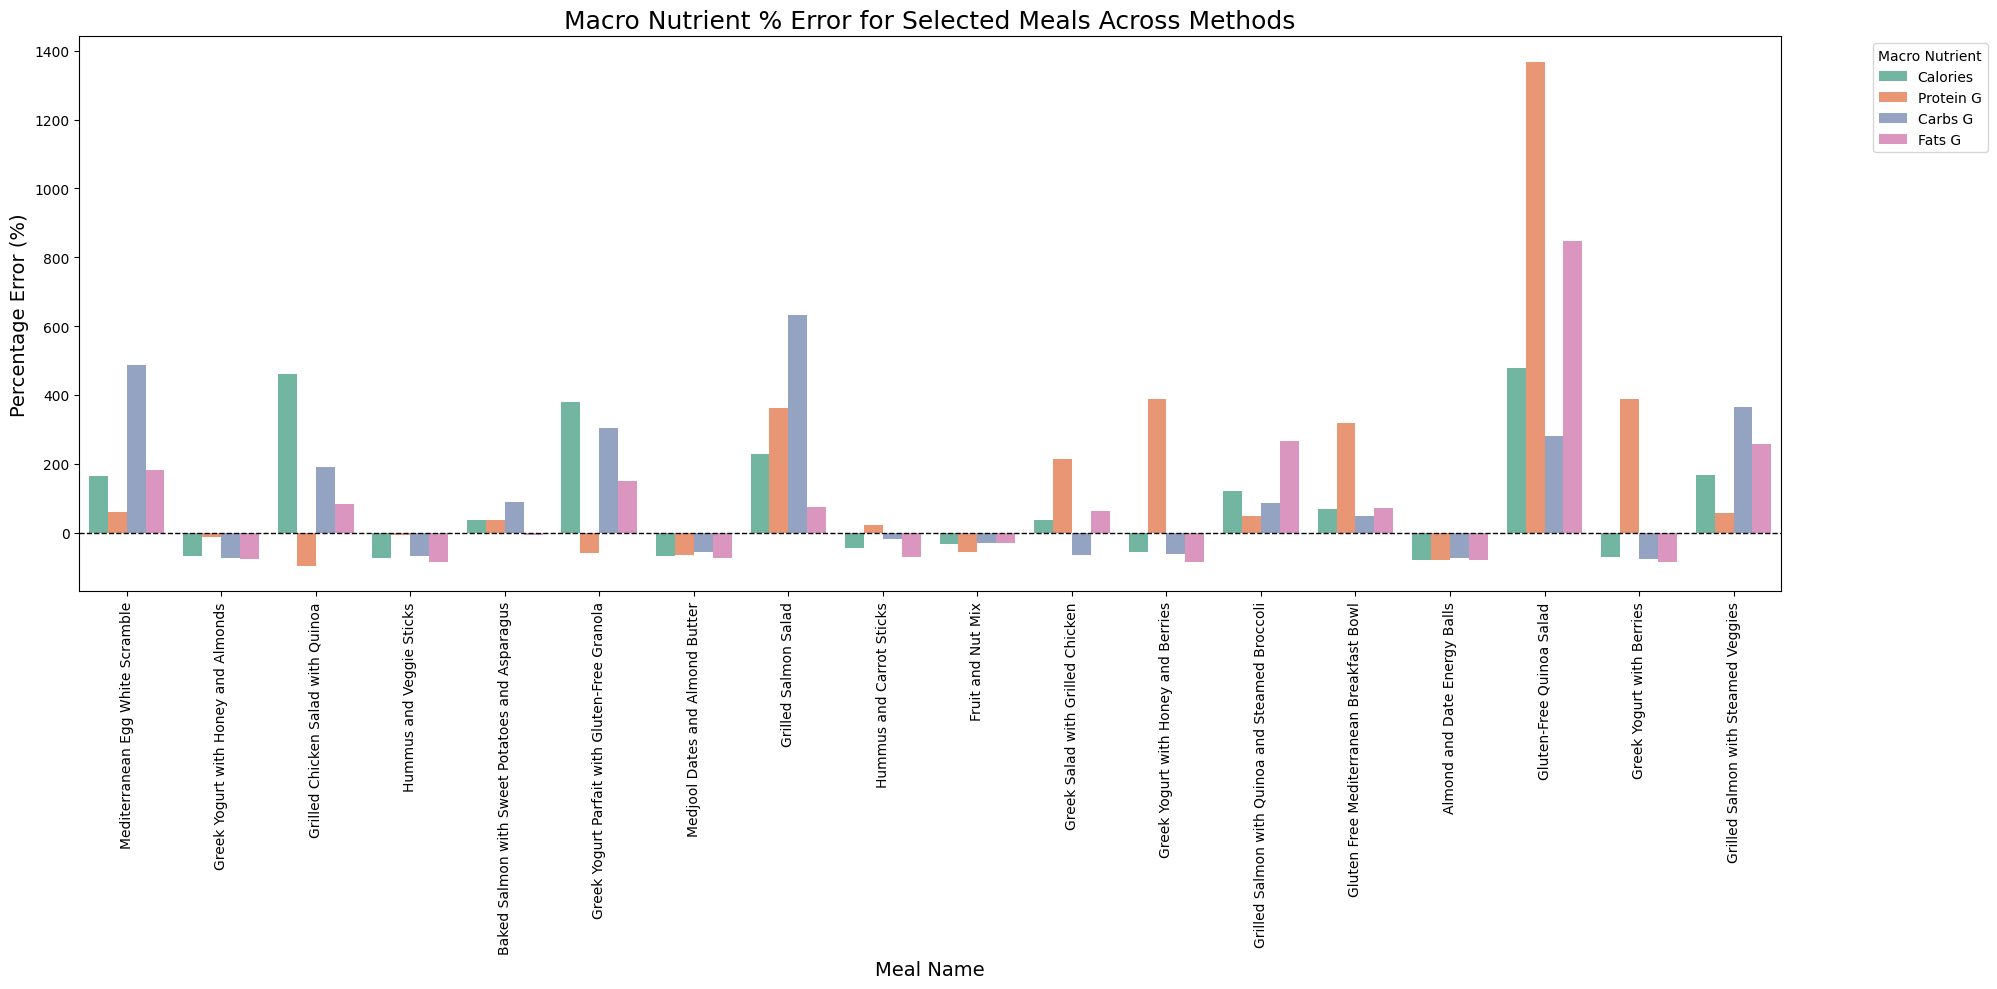

In [25]:
# 🎨 Plot
plt.figure(figsize=(20, 10))
sns.barplot(
    data=melted_df,
    x="meal_name", y="error_pct",
    hue="macro",
    palette="Set2",
    dodge=True
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Macro Nutrient % Error for Selected Meals Across Methods", fontsize=18)
plt.xlabel("Meal Name", fontsize=14)
plt.ylabel("Percentage Error (%)", fontsize=14)
plt.xticks(rotation=90)
plt.legend(title="Macro Nutrient", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [26]:

from dotenv import load_dotenv
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment
load_dotenv("../.env", override=True)
APP_ID = os.getenv("NUTRITIONIX_APP_ID")
API_KEY = os.getenv("NUTRITIONIX_API_KEY")

headers = {
    "x-app-id": APP_ID,
    "x-app-key": API_KEY,
    "Content-Type": "application/json"
}

# 🛠️ Nutritionix API call
def get_nutritionix_meal(meal_name):
    url = "https://trackapi.nutritionix.com/v2/natural/nutrients"
    data = {"query": meal_name}
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"❌ Error {response.status_code}: {response.text}")
        return None

# 🛠️ Process the Nutritionix response
def process_nutritionix_response(response_json):
    if not response_json or 'foods' not in response_json:
        return None
    
    total_cals, total_protein, total_carbs, total_fats = 0, 0, 0, 0
    
    for food in response_json['foods']:
        total_cals += food.get('nf_calories', 0)
        total_protein += food.get('nf_protein', 0)
        total_carbs += food.get('nf_total_carbohydrate', 0)
        total_fats += food.get('nf_total_fat', 0)
    
    return {
        "calories": total_cals,
        "protein_g": total_protein,
        "carbs_g": total_carbs,
        "fats_g": total_fats
    }

# 🛠️ Comparison function
def compare_meal_nutrition(llm_meal, real_meal):
    comparison = {}
    for macro in ['calories', 'protein_g', 'carbs_g', 'fats_g']:
        llm_val = llm_meal.get(macro, 0)
        real_val = real_meal.get(macro, 0)
        
        if real_val != 0:
            error_pct = ((llm_val - real_val) / real_val) * 100
        else:
            error_pct = None  # Can't divide by zero
        
        comparison[f"{macro}_error_pct"] = error_pct
        
    return comparison



In [31]:
# 📦 Store results
all_comparisons = []

for method, df in loaded_datasets.items():
    print(f"🔎 Processing {method}...")
    
    for idx, row in df.iterrows():
        meal_name = row.get('meal_name', None)
        if not meal_name or pd.isnull(meal_name):
            continue
        
        try:
            # 📥 Nutritionix search
            response_json = get_nutritionix_meal(meal_name)
            nutritionix_meal = process_nutritionix_response(response_json)
            
            if not nutritionix_meal:
                continue
            
            llm_meal = {
                "calories": row.get('calories', 0),
                "protein_g": row.get('protein_g', 0),
                "carbs_g": row.get('carbs_g', 0),
                "fats_g": row.get('fats_g', 0)
            }
            
            comparison = compare_meal_nutrition(llm_meal, nutritionix_meal)
            comparison.update({
                "user_id": row.get('user_id', ''),
                "meal_name": meal_name,
                "method": method
            })
            
            all_comparisons.append(comparison)
        
        except Exception as e:
            print(f"❌ Error processing meal {meal_name}: {e}")
            continue

# 📋 Create DataFrame
comparison_df = pd.DataFrame(all_comparisons)

# 🖨️ Quick view
display(comparison_df.head())


🔎 Processing guided...
❌ Error 401: {"message":"usage limits exceeded","id":"9db4f042-22c7-4b65-a19d-48c1f9811e4c"}
❌ Error 401: {"message":"usage limits exceeded","id":"45d5b1a9-5235-4197-9dab-29fbaf6de9ed"}
❌ Error 401: {"message":"usage limits exceeded","id":"cf87d19c-9789-4d93-8119-d9d4f695b2f4"}
❌ Error 401: {"message":"usage limits exceeded","id":"bb1a1064-61ae-4634-9196-42fd9e6e5850"}
❌ Error 401: {"message":"usage limits exceeded","id":"cefbf3f1-141e-40e9-a813-52a038a7672f"}
❌ Error 401: {"message":"usage limits exceeded","id":"a98553ea-a161-4cd5-8dbd-108cb07b22d9"}
❌ Error 401: {"message":"usage limits exceeded","id":"6f51bad4-b906-434c-ae80-b8f83d59b82e"}
❌ Error 401: {"message":"usage limits exceeded","id":"902f8f5c-c2c4-4a91-8cae-3d6fcd4a8e99"}
❌ Error 401: {"message":"usage limits exceeded","id":"ede193a8-8cda-43b5-9149-04034f8c33eb"}
❌ Error 401: {"message":"usage limits exceeded","id":"d0301944-4cba-406d-95ef-738c3e73ea83"}
❌ Error 401: {"message":"usage limits exceeded"

KeyboardInterrupt: 

In [ ]:
# comparison_df_df = comparison_df[comparison_df['meal_name'] != "Mediterranean Egg White Scramble"]

/tmp/ipykernel_255703/3921985505.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_meal_df = comparison_df.groupby('method').apply(lambda x: x.head(5)).reset_index(drop=True)


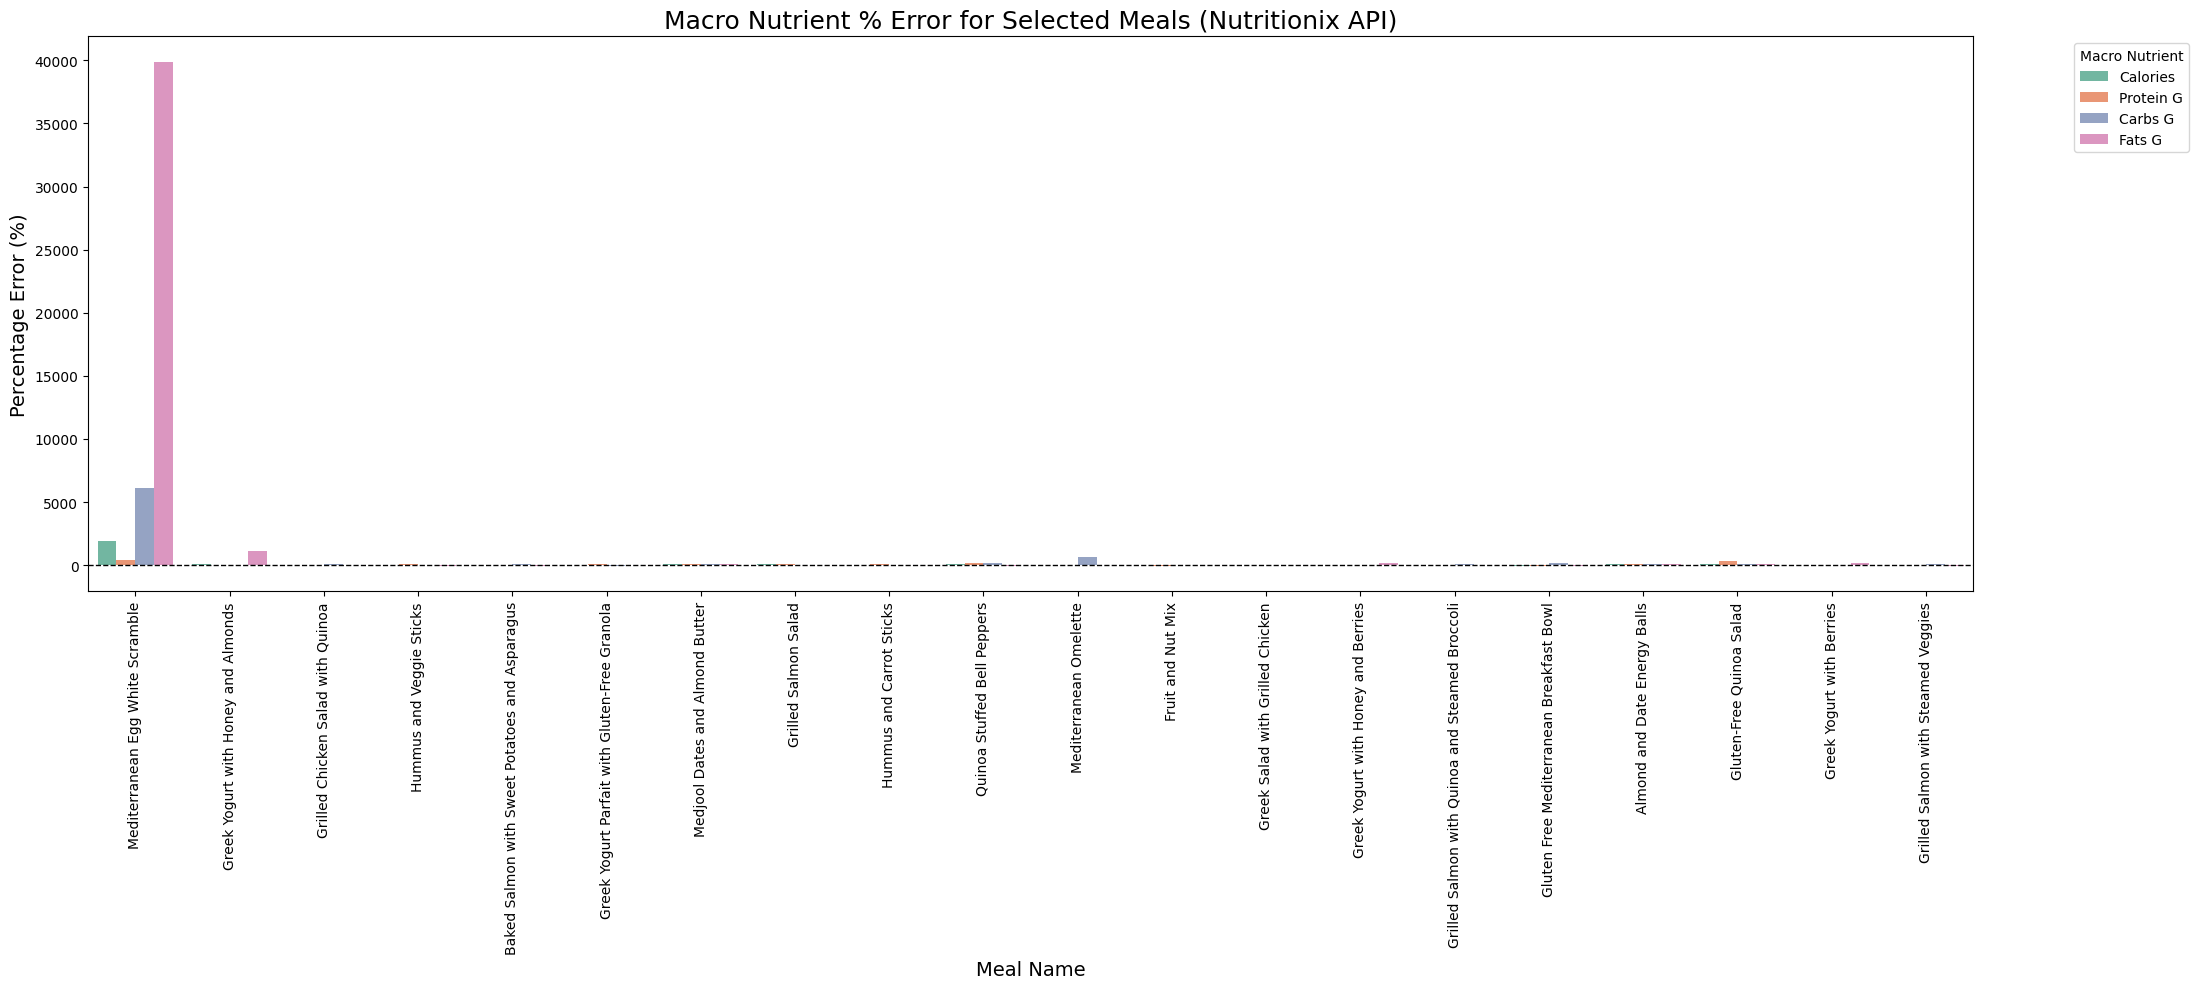

In [30]:
# 📋 Pick 5 meals automatically per method
selected_meal_df = comparison_df.groupby('method').apply(lambda x: x.head(5)).reset_index(drop=True)

# 📋 Melt macros for plotting
macro_error_cols = ['calories_error_pct', 'protein_g_error_pct', 'carbs_g_error_pct', 'fats_g_error_pct']

melted_df = selected_meal_df.melt(
    id_vars=["user_id", "meal_name", "method"],
    value_vars=macro_error_cols,
    var_name="macro",
    value_name="error_pct"
)

# 📋 Clean macro names
melted_df['macro'] = melted_df['macro'].str.replace('_error_pct', '').str.replace('_', ' ').str.title()

# 🎨 Plot
plt.figure(figsize=(22, 10))
sns.barplot(
    data=melted_df,
    x="meal_name", y="error_pct",
    hue="macro",
    palette="Set2",
    dodge=True
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Macro Nutrient % Error for Selected Meals (Nutritionix API)", fontsize=18)
plt.xlabel("Meal Name", fontsize=14)
plt.ylabel("Percentage Error (%)", fontsize=14)
plt.xticks(rotation=90)
plt.legend(title="Macro Nutrient", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ValueError: 'uppe/r left' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

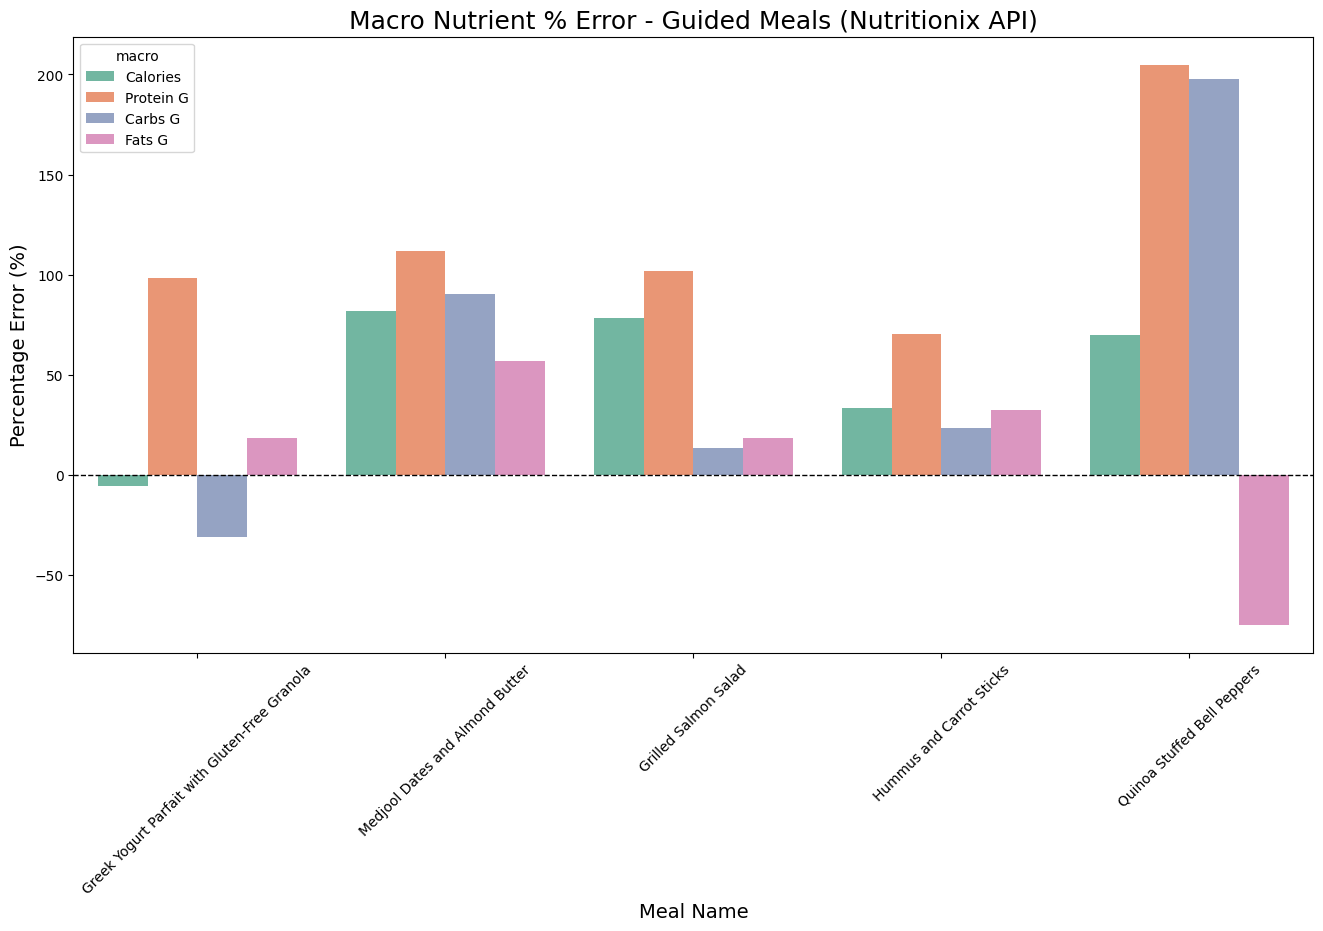

In [32]:
# 🎨 Plot separately per method
methods = comparison_df['method'].unique()

for method in methods:
    method_df = comparison_df[comparison_df['method'] == method]
    
    if method_df.empty:
        print(f"⚠️ No data for {method}, skipping...")
        continue
    
    # Pick 5 meals
    selected_meal_df = method_df.head(5)

    # Melt for plotting
    macro_error_cols = ['calories_error_pct', 'protein_g_error_pct', 'carbs_g_error_pct', 'fats_g_error_pct']
    
    melted_df = selected_meal_df.melt(
        id_vars=["user_id", "meal_name", "method"],
        value_vars=macro_error_cols,
        var_name="macro",
        value_name="error_pct"
    )

    # Clean macro names
    melted_df['macro'] = melted_df['macro'].str.replace('_error_pct', '').str.replace('_', ' ').str.title()

    # 🎨 Plot
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=melted_df,
        x="meal_name", y="error_pct",
        hue="macro",
        palette="Set2",
        dodge=True
    )
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Macro Nutrient % Error - {method.title()} Meals (Nutritionix API)", fontsize=18)
    plt.xlabel("Meal Name", fontsize=14)
    plt.ylabel("Percentage Error (%)", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Macro Nutrient", bbox_to_anchor=(1.05, 1), loc='uppe/r left')
    plt.tight_layout()
    plt.show()
